# Counting cells using YOLOv5

YOLOv5: https://github.com/ultralytics/yolov5

---
Author of this notebook: Andre Telfer (andretelfer@cmail.carleton.ca)

In [151]:
pip install shapely

Note: you may need to restart the kernel to use updated packages.


In [152]:
import matplotlib.pyplot as plt
import numpy as np
import shapely.geometry
import napari
import pandas as pd

from tqdm import tqdm
from pathlib import Path
from skimage.io import imread, imsave

## What does our dataset look like?
Our dataset is just a folder containing `.png` images of cfos stains

In [2]:
DATA_DIR = Path("/home/andretelfer/shared/curated/brenna/cfos-examples/original")

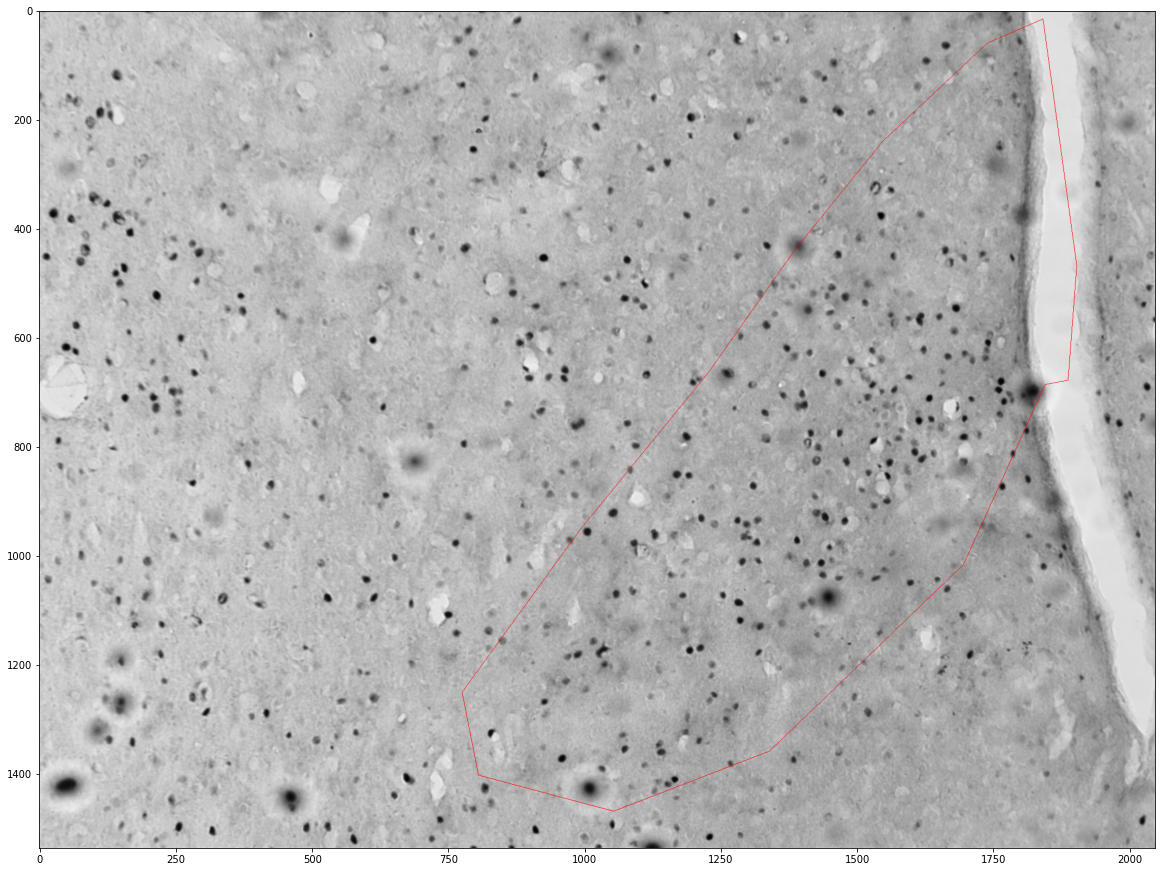

In [171]:
plt.figure(figsize=(20,20))
sample_image = next(DATA_DIR.glob('*.png'))
image = imread(sample_image)
plt.imshow(image)

## Create a new dataset by sampling sections of the original dataset

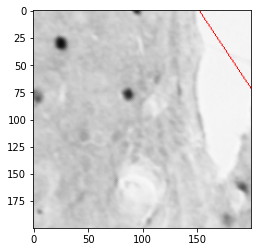

In [66]:
SIZE = 200 # size of new images in pixels
SAMPLES_PER_IMAGE = 5

def subsample_image(imagepath, samples):
    image = imread(imagepath)
    h,w,c = image.shape
    locations = np.stack([
        np.random.randint(0,h-SIZE,samples),
        np.random.randint(0,w-SIZE,samples)
    ]).T
    
    images = []
    for (i,j) in locations:
        new_image = np.zeros(shape=(SIZE,SIZE))
        new_image = image[i:i+SIZE, j:j+SIZE]
        images.append({
            'image': new_image,
            'x': j,
            'y': i,
            'path': imagepath
        })
        
    return images

sampled_images = []
for image in DATA_DIR.glob('*.png'):
    sampled_images += subsample_image(image, SAMPLES_PER_IMAGE)
    
plt.imshow(sampled_images[5]['image'])

## Save the images to a new directory 

In [67]:
OUTPUT_DIR = Path("/home/andretelfer/shared/curated/brenna/cfos-examples/subsamples")

! rm -rf {OUTPUT_DIR}
! mkdir -p {OUTPUT_DIR}

for item in sampled_images:
    image = item['image']
    fname = item['path'].parts[-1].split('.')[0]
    
    output_file = f"{fname}_{item['x']}x_{item['y']}y.png"
    imsave(OUTPUT_DIR / output_file, image)

In [68]:
ls {OUTPUT_DIR}

Rat2slide1sample3-L_1233x_940y.png   Rat2slide1sample4-R_1204x_167y.png
Rat2slide1sample3-L_1590x_1090y.png  Rat2slide1sample4-R_1305x_650y.png
Rat2slide1sample3-L_318x_563y.png    Rat2slide1sample4-R_1379x_275y.png
Rat2slide1sample3-L_463x_853y.png    Rat2slide1sample4-R_1748x_549y.png
Rat2slide1sample3-L_938x_1158y.png   Rat2slide1sample4-R_548x_1211y.png
Rat2slide1sample3-R_1098x_469y.png   Rat2slide1sample5-L_141x_972y.png
Rat2slide1sample3-R_1330x_289y.png   Rat2slide1sample5-L_1571x_1231y.png
Rat2slide1sample3-R_1668x_1115y.png  Rat2slide1sample5-L_1682x_207y.png
Rat2slide1sample3-R_57x_24y.png      Rat2slide1sample5-L_599x_606y.png
Rat2slide1sample3-R_86x_1233y.png    Rat2slide1sample5-L_950x_105y.png
Rat2slide1sample4-L_1494x_1106y.png  Rat2slide1sample5-R_109x_569y.png
Rat2slide1sample4-L_1654x_619y.png   Rat2slide1sample5-R_52x_919y.png
Rat2slide1sample4-L_1678x_517y.png   Rat2slide1sample5-R_716x_891y.png
Rat2slide1sample4-L_1779x_1332y.png  Rat2slide1sample5-R_79x_843y.png


## Labeling the Images
For this step, the [YOLOv5 documentation](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data) recommended [roboflow](https://app.roboflow.com/).

I created a free-tier account and started labelling. 

I modified the tutorial by not including a scaling preprocessing step. I did this because the size of the cell matters and I wanted to preserve that information
- there are some large splotches that are cell shaped, but are not cells
- there are small speckles which are not cells


<img src='assets/Screenshot from 2022-06-11 09-02-36.png' />

## Training a Model
The YOLOv5 guide came with a [Google Colab notebook](https://colab.research.google.com/github/roboflow-ai/yolov5-custom-training-tutorial/blob/main/yolov5-custom-training.ipynb) that was easy to modify to my own examples (dataset, image sizes, etc)
- Following the guide, I changed the dataset to the one we created in RoboFlow
- In order to preserve information about cell size, for training I set the image size to be the same as the actual image size for the sampled training images. When running inference/detection, I used the full image size (e.g. ~2000px in my case).

<img src="assets/Screenshot from 2022-06-12 08-21-10.png"/>

## Inference and Results
I uploaded the original images to google drive separately and modified the notebook to use them

The results were overall quite good, although I later found I should've labeled more of the lighter cells in the training data; so the model also misses the lighter cells.
<img src="assets/yolov5-results/Rat2slide1sample3-L.png"/>

## Interacting with the results (correcting/viewing)
This will allow us to add/remove cells that were missed
<img src="assets/Screenshot from 2022-06-12 09-58-54.png"/>

### Loading the YOLO labels

In [74]:
all_vertices = []

for idx, p in enumerate(sorted(LABEL_DIR.glob("*.txt"))):
    with open(p, 'r') as fp:
        lines = fp.readlines()
    
    # Turn the data into a dataframe
    data = [l.strip().split(' ') for l in lines]
    df = pd.DataFrame(data, columns=['0', 'x', 'y', 'w', 'h', 'c']).astype(float)

    # Drop low confidence frames
    df = df[df.c > 0.2]
    
    # Scale by image size
    fname, _ = p.parts[-1].split('.')
    image = imread(DATA_DIR / f"{fname}.png")
    h, w, c = image.shape
    df.y *= h
    df.h *= h
    df.x *= w
    df.w *= w
    
    # Get x,y vertices for rectangle
    i = np.ones(shape=df.shape[0])*idx
    vertices = np.array([
        [i, df.y-df.h/2, df.x-df.w/2],
        [i, df.y+df.h/2, df.x-df.w/2],
        [i, df.y+df.h/2, df.x+df.w/2],
        [i, df.y-df.h/2, df.x+df.w/2]
    ]).transpose(2, 0, 1)
    all_vertices.append(vertices)
    
all_vertices = np.concatenate(all_vertices)

### Viewing them with Napari

In [77]:

# The YOLOv5 labels
LABEL_DIR = Path("assets/yolov5-results/labels")

viewer = napari.Viewer()

# Add the images
images = np.array([imread(p) for p in sorted(DATA_DIR.glob("*.png"))])
image_layer = viewer.add_image(np.array(images))

# Add the yolov5 labels
shape_layer = viewer.add_shapes(all_vertices, face_color=[1., 0., 0., 0.3])

/home/andretelfer/anaconda3/envs/napari-env/lib/python3.9/site-packages/napari_tools_menu/__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


## Getting cell counts

In [116]:
shape_layer.save('assets/cells.csv')
cells_df = pd.read_csv('assets/cells.csv')
cells_df.head(3)

index shape-type  vertex-index  axis-0       axis-1      axis-2
0      0  rectangle             0     0.0  1041.999713  255.000033
1      0  rectangle             1     0.0  1054.999711  255.000033
2      0  rectangle             2     0.0  1054.999711  264.000031

In [127]:
cells_df = cells_df.rename(columns={'axis-0': 'image', 'axis-1': 'y', 'axis-2' : 'x', 'index': 'cell'})
cells_df.head(5)

cell shape-type  vertex-index  image            y           x
0     0  rectangle             0    0.0  1041.999713  255.000033
1     0  rectangle             1    0.0  1054.999711  255.000033
2     0  rectangle             2    0.0  1054.999711  264.000031
3     0  rectangle             3    0.0  1041.999713  264.000031
4     1  rectangle             0    0.0    17.000033  257.000059

Finally, we can get the cell counts for each image

In [169]:
cell_counts = cells_df.groupby('image').apply(lambda x: len(x.cell.unique()))

image
0.0    507
1.0    678
2.0    637
3.0    681
4.0    499
5.0    685
Name: cell_count, dtype: int64

## Getting cells in an area

<img src="assets/Screenshot from 2022-06-12 10-17-28.png"/>

In [120]:
zone_layer = viewer.add_shapes(name='zone', ndim=3, edge_color='red', face_color=[0.,0.,1.,0.3])

<Shapes layer 'zone' at 0x7efd53ce31c0>

Traceback (most recent call last):
  File "/home/andretelfer/anaconda3/envs/napari-env/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 532, in mouseMoveEvent
    self._vispy_mouse_move(
  File "/home/andretelfer/anaconda3/envs/napari-env/lib/python3.9/site-packages/vispy/app/base.py", line 216, in _vispy_mouse_move
    ev = self._vispy_canvas.events.mouse_move(**kwargs)
  File "/home/andretelfer/anaconda3/envs/napari-env/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/andretelfer/anaconda3/envs/napari-env/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/andretelfer/anaconda3/envs/napari-env/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/andretelfer/anaconda3/envs/napari-env/lib/python3.9/site-packages/napari/_qt/qt_viewer.py", line 960, in on_mo

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 507/507 [00:00<00:00, 2086.06it/s]


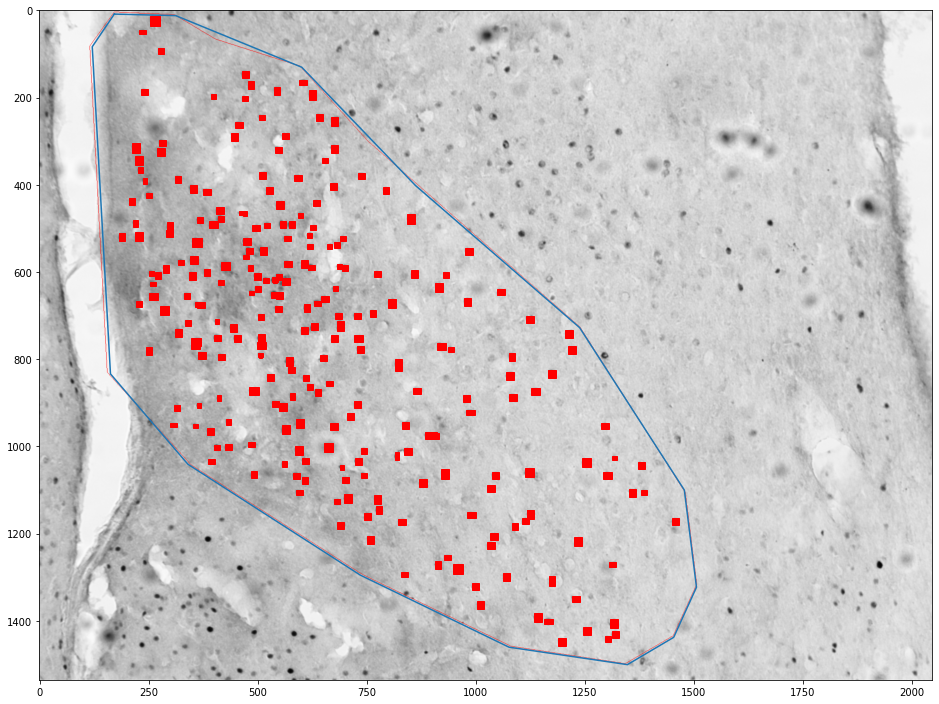

Cell count 253
Density 212.8925598329929



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 678/678 [00:00<00:00, 2406.08it/s]


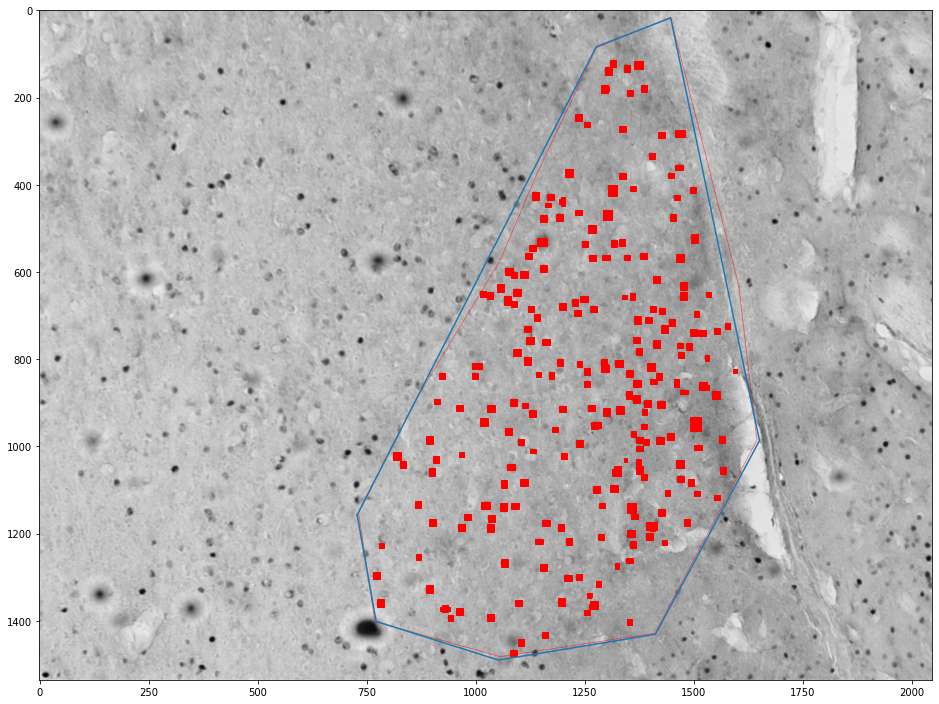

Cell count 237
Density 287.37546350839864



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 637/637 [00:00<00:00, 2235.87it/s]


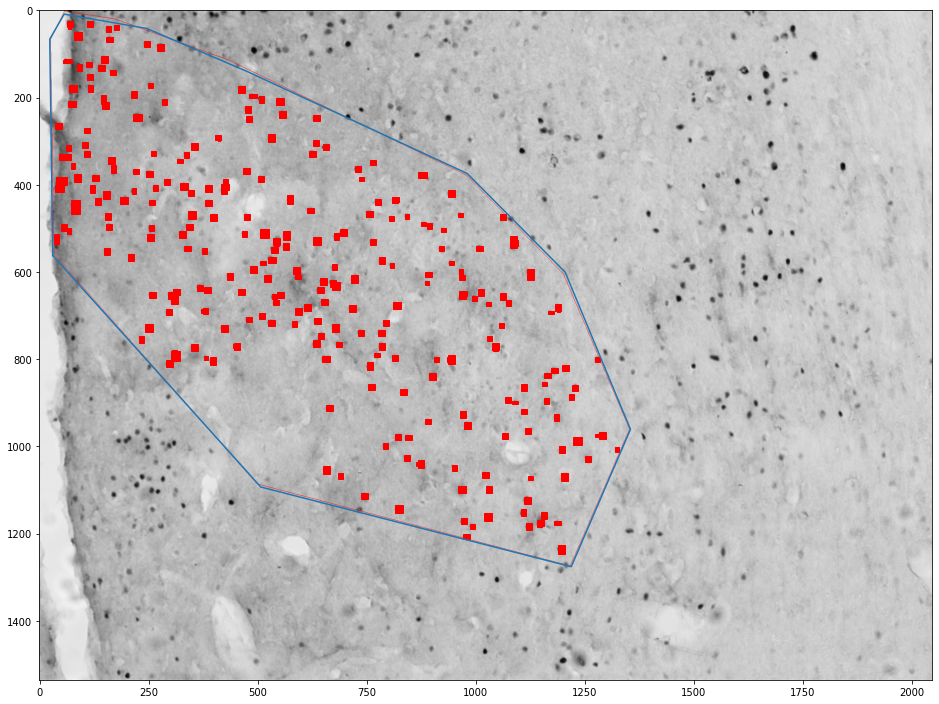

Cell count 280
Density 277.3213753614854



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 681/681 [00:00<00:00, 2398.25it/s]


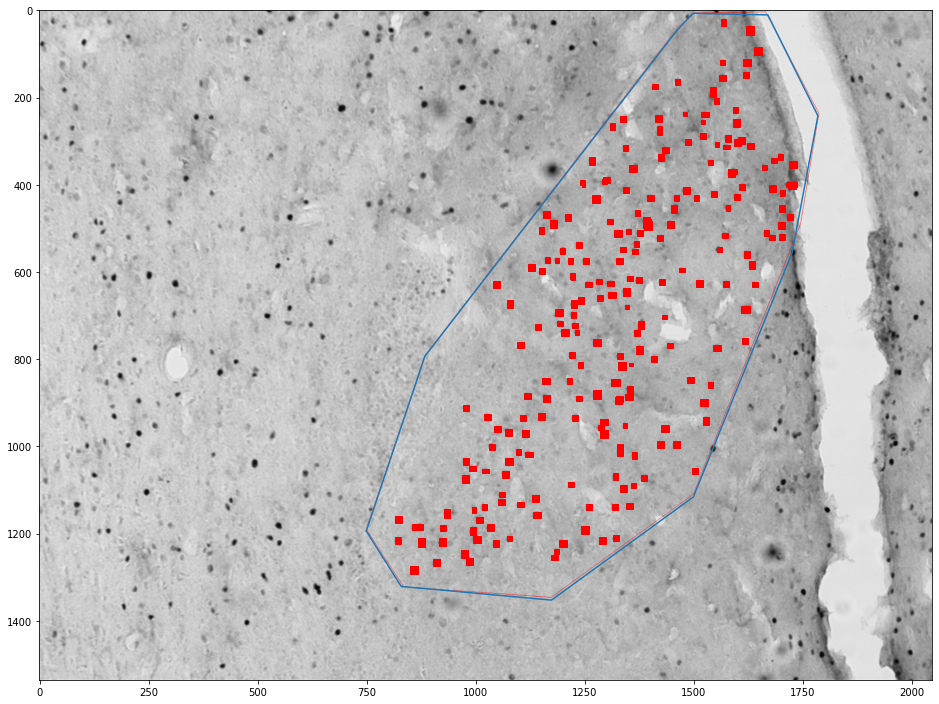

Cell count 231
Density 294.89183180541426



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 2362.33it/s]


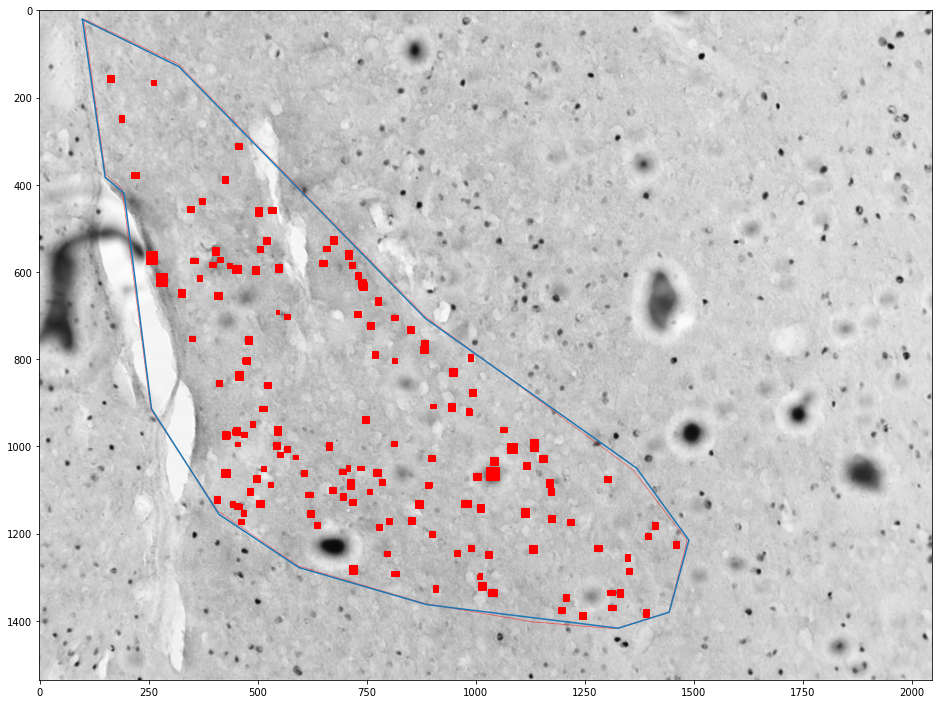

Cell count 155
Density 180.41495343681075



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 685/685 [00:00<00:00, 2353.12it/s]


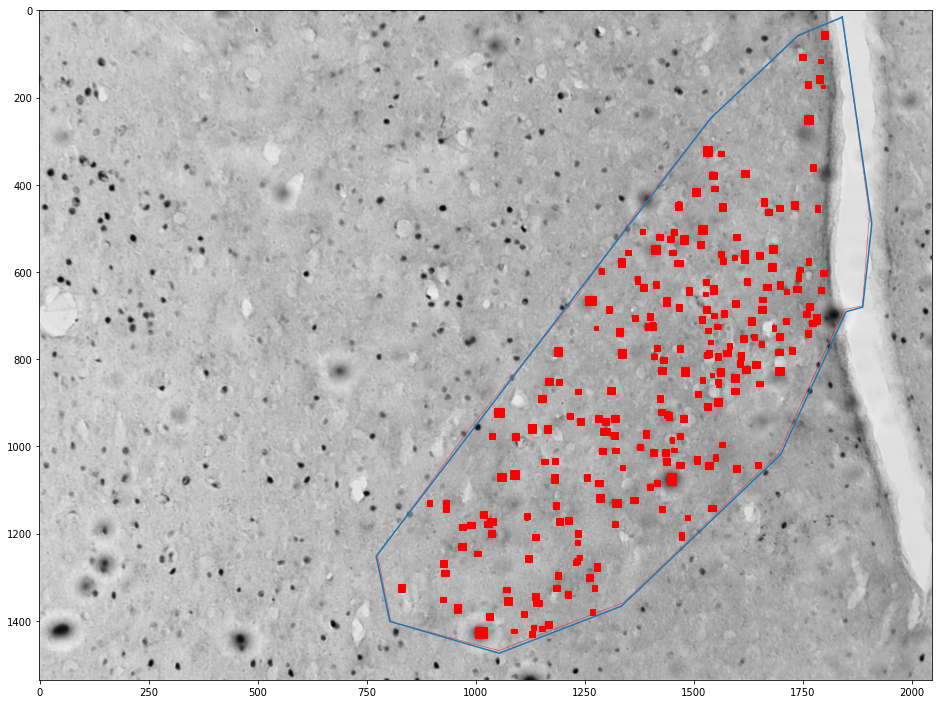

Cell count 238
Density 306.52820841199133



In [174]:
zone_layer.save('assets/zones.csv')
zone_df = pd.read_csv('assets/zones.csv')
zone_df = zone_df.rename(columns={'axis-0': 'image', 'axis-1': 'y', 'axis-2' : 'x'})

cells_by_image = cells_df.groupby('image')
zones_by_image = zone_df.groupby('image')

for (idx, zone), (idx, cells) in zip(zones_by_image, cells_by_image):
    zone = shapely.geometry.Polygon(zone[['x', 'y']].values)
    
    plt.figure(figsize=(16,16))
    plt.imshow(images[int(idx)])
    x,y = zone.exterior.xy
    plt.plot(x,y)
    ax = plt.gca()
    
    count = 0
    for _, cell in tqdm(cells.groupby('cell')):
        cell = shapely.geometry.Polygon(cell[['x', 'y']].values)
        if zone.contains(cell):
            count += 1
            ax.add_patch(plt.Polygon(np.stack(cell.exterior.xy).T, color='red'))
    
    plt.show()
    
    print("Cell count", count)
    print("Density", count / zone.area * 1e6)
    print()